# Casus opdracht - Credit

In dit notebook doorlopen we onze data pipeline en laten hier de door ons genomen stappen om antwoord te geven op de onderstaande onderzoeksvragen zien.

## Onderzoeksvragen

1. In hoeverre is het mogelijk om te voorspellen of iemand betalingsachterstanden gaat krijgen op basis van diverse persoonskenmerken?
2. Zelf te bepalen: er is een dataset beschikbaar met eerdere creditcardaanvragen.
3. In hoeverre is het mogelijk om logische clusters van consumenten (bijv. AMT_INCOME_TOTAL, DAYS_EMPLOYED, CNT_FAM_MEMBERS) en hun leningen te vinden (bijv. AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE)? Denk aan consumenten met (te)veel, weinig of geen leningen.

## Importeren van Benodigde Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Data Verkennen en Analyseren

- Meetwaardes bepalen
- Centrummaten
- Verdeling in data inzichtelijk maken (boxplots? )
- Zijn er outliers? None waardes?
- Correlaties?
- Conclussies?


### Data Inlezen


In [2]:
credit = pd.read_csv('application_data.csv', sep=',') 

# Hernaming van de kolommen. Dit is vooral voor gebruiksgemak en heeft geen verdere betekenis.
credit = credit.rename(columns={
    'TARGET': 'target', 
    'NAME_CONTRACT_TYPE': 'contract_type',
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'owns_car',
    'CNT_FAM_MEMBERS': 'count_fam_members',
    'AMT_INCOME_TOTAL': 'total_income',
    'AMT_CREDIT': 'credit_amount',
    'FLAG_CONT_MOBILE': 'is_reachable',
    'REGION_RATING_CLIENT_W_CITY': 'region_rating_w_city',
    'DAYS_BIRTH': 'age_in_days',
    'DAYS_EMPLOYED': 'days_employed'
    })

credit = credit[credit.gender != 'XNA']
credit.gender.replace(['M', 'F'], [0, 1], inplace=True)

credit.head()

,SK_ID_CURR,target,contract_type,gender,owns_car,FLAG_OWN_REALTY,CNT_CHILDREN,total_income,credit_amount,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,0,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,1,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,0,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,1,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,0,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Inladen van kolomnbeschrijvingen.
columns_desc = pd.read_csv('columns_description.csv', sep=',')
columns_desc = columns_desc[columns_desc['Table'] == 'application_data']

columns_desc

,Unnamed: 0,Table,Row,Description,Special
0,1,application_data,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_data,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_data,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_data,CODE_GENDER,Gender of the client,NaN
4,7,application_data,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
117,120,application_data,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
118,121,application_data,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
119,122,application_data,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
120,123,application_data,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN


### Kiezen featurevariabelen

We hebben geen productowner of domeinkennis. Daarom moet er een andere manier zijn om te bepalen welke featurevariabelen we gaan gebruiken. In dit geval hebben we gekozen op basis van een correlatieonderzoek en wat wij denken dat nuttige variabelen zijn.

Voor de correlatieonderzoek kijken we eerst wat de correlatie tot de targetvariabele is voor elke variabele.

In [4]:
target_correlation = credit.corr().target.sort_values(ascending=False)
target_correlation

target                    1.000000
age_in_days               0.078242
region_rating_w_city      0.060895
REGION_RATING_CLIENT      0.058901
DAYS_LAST_PHONE_CHANGE    0.055219
                            ...   
days_employed            -0.044934
gender                   -0.054710
EXT_SOURCE_1             -0.155317
EXT_SOURCE_2             -0.160471
EXT_SOURCE_3             -0.178926
Name: target, Length: 107, dtype: float64

Deze tabel laat nog te veel informatie zien dus knippen we het midden (-0.04 < corr < 0.055) eruit.

In [5]:
target_correlation_ = target_correlation[(target_correlation > 0.055) | (target_correlation < -0.04)]
target_correlation_

target                    1.000000
age_in_days               0.078242
region_rating_w_city      0.060895
REGION_RATING_CLIENT      0.058901
DAYS_LAST_PHONE_CHANGE    0.055219
FLOORSMAX_MODE           -0.043231
FLOORSMAX_MEDI           -0.043773
FLOORSMAX_AVG            -0.044009
days_employed            -0.044934
gender                   -0.054710
EXT_SOURCE_1             -0.155317
EXT_SOURCE_2             -0.160471
EXT_SOURCE_3             -0.178926
Name: target, dtype: float64

De variabele met de grootste correlatie zijn EXT_SOURCE_1, 2 en 3 maar de beschrijving van deze kolommen geeft ons ziet veel informatie. Tenzij we ergens anders kunnen vinden wat het betekent hebben we niet veel aan deze kolommen.

In [6]:
columns_desc[columns_desc['Row'].isin(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])][['Row', 'Description']]

,Row,Description
41,EXT_SOURCE_1,Normalized score from external data source
42,EXT_SOURCE_2,Normalized score from external data source
43,EXT_SOURCE_3,Normalized score from external data source


Verder kunnen we zien dat de variabelen DAYS_BIRTH, REGION_RATING_CLIENT_W_CITY, REGION_RATING_CLIENT, CODE_GENDER en DAYS_EMPLOYED een relatief sterke correlatie hebben dus kunnen we deze als featurevariabelen nemen. Echter zijn REGION_RATING_CLIENT en REGION_RATING_CLIENT_W_CITY praktisch dezelfde variabelen dus kiezen we om alleen de tweede te grbruiken.

Ook kiezen we de volgende variabelen omdat we denken dat ze invloed kunnen hebben op de target: 
    - NAME_CONTRACT_TYPE
    - AMT_INCOME_TOTAL
    - AMT_CREDIT

In [7]:
feature_vars = ['gender', 'region_rating_w_city', 'age_in_days', 'days_employed', 'contract_type', 
                'total_income', 'credit_amount']
target_var = ['target']

feature_table = credit[(feature_vars + target_var)]

feature_table.head()

,gender,region_rating_w_city,age_in_days,days_employed,contract_type,total_income,credit_amount,target
0,0,2,-9461,-637,Cash loans,202500.0,406597.5,1
1,1,1,-16765,-1188,Cash loans,270000.0,1293502.5,0
2,0,2,-19046,-225,Revolving loans,67500.0,135000.0,0
3,1,2,-19005,-3039,Cash loans,135000.0,312682.5,0
4,0,2,-19932,-3038,Cash loans,121500.0,513000.0,0


### Meetwaardes bepalen

Om te beginnen kiezen we eerst een aantal featurevariabelen. Dit doen we op basis van het correlatiecoefficient. Daarmee kijken we hoe sterk alle variabelen correleren met het targetvariabele (target).
Om te beginnen hebben we een aantal features uitgekozen waarvan wij denken dat deze van grote invloed kunnen zijn op onze target variabele. Deze lijst kan later nog gewijzigd worden na het doen van een correlatieonderzoek.

In [8]:
feature_table.dtypes

gender                    int64
region_rating_w_city      int64
age_in_days               int64
days_employed             int64
contract_type            object
total_income            float64
credit_amount           float64
target                    int64
dtype: object

In [9]:
feature_table.describe()

,gender,region_rating_w_city,age_in_days,days_employed,total_income,credit_amount,target
count,307507.000000,307507.000000,307507.000000,307507.000000,3.075070e+05,3.075070e+05,307507.00000
mean,0.658352,2.031518,-16037.027271,63815.929208,1.687977e+05,5.990286e+05,0.08073
std,0.474263,0.502737,4363.982424,141276.472519,2.371246e+05,4.024926e+05,0.27242
min,0.000000,1.000000,-25229.000000,-17912.000000,2.565000e+04,4.500000e+04,0.00000
25%,0.000000,2.000000,-19682.000000,-2760.000000,1.125000e+05,2.700000e+05,0.00000
50%,1.000000,2.000000,-15750.000000,-1213.000000,1.471500e+05,5.135310e+05,0.00000
75%,1.000000,2.000000,-12413.000000,-289.000000,2.025000e+05,8.086500e+05,0.00000
max,1.000000,3.000000,-7489.000000,365243.000000,1.170000e+08,4.050000e+06,1.00000


| naam (origineel) | naam (aangepast) | beschrijving | afhankelijk | datatype | meetniveau |
| ---------------- | ---------------- | ------------ | ----------- | -------- | ---------- |
| DAYS_BIRTH | age_in_days | leeftijd van klant in dagen | nee | int | discreet |
| REGION_RATING_CLIENT_W_CITY | region_rating_w_city | Beoordeling van de regio waar de klant woont waar rekening is gehouden met de stad (1, 2, 3). | nee | int | discreet |
| CODE_GENDER | gender | Geslacht van klant | nee | int | nominaal (in de vorm van een discrete waarde) |
| DAYS_EMPLOYED | days_employed | Hoeveelheid aan dagen dat de klant hun huidige baan heeft op het moment van aanvragen | nee | int | discreet |
| NAME_CONTRACT_TYPE | contract_type | Type contract (revolving of cash) | nee | object (string) | nominaal |
| AMT_INCOME_TOTAL | total_income | Totale inkomen van de klant | nee | float | continu |
| AMT_CREDIT | credit_amount | Hoeveelheid credit in de lening | nee | float | continu |

### Centrum- en Spreidingsmaten

TODO: verwijder wetenschappelijke notatie

In de onderstaande grafieken zijn twee boxplots te zien. Een van het totale inkomen, en een van de hoogte van de kredieten. 

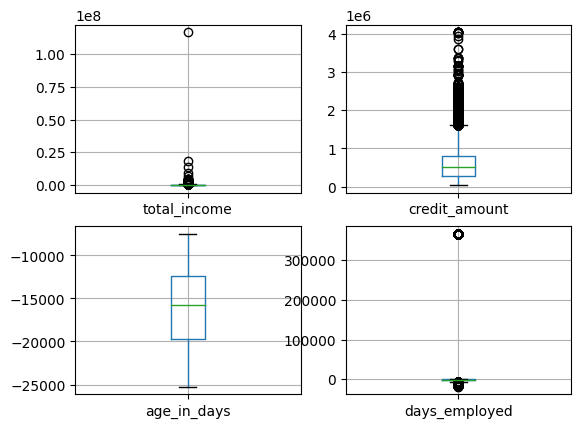

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2)

credit.total_income.plot.box(ax=axes[0, 0], grid=True)
credit.credit_amount.plot.box(ax=axes[0, 1], grid=True)

credit.age_in_days.plot.box(ax=axes[1, 0], grid=True)
credit.days_employed.plot.box(ax=axes[1, 1], grid=True);

Bij total_income, credit_amount en days_emplyed zijn veel uitschieters.

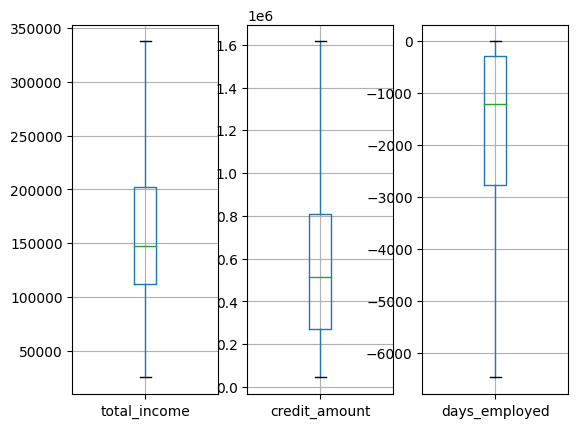

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3)

credit.total_income.plot.box(ax=axes[0], grid=True, showfliers=False)
credit.credit_amount.plot.box(ax=axes[1], grid=True, showfliers=False)
credit.days_employed.plot.box(ax=axes[2], grid=True, showfliers=False);

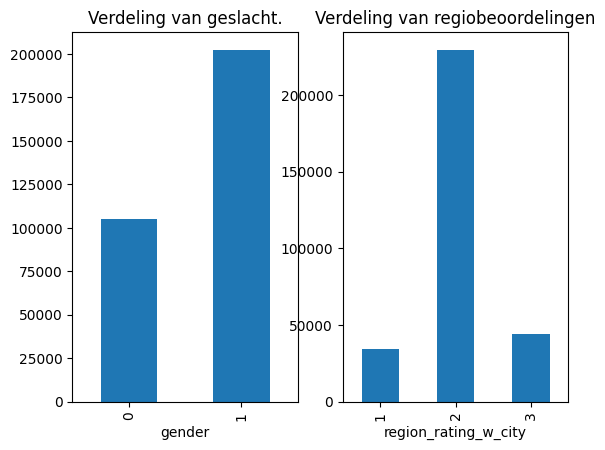

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2)

credit.groupby(by='gender').gender\
                           .count()\
                           .plot\
                           .bar(ax=axes[0], title='Verdeling van geslacht')

credit.groupby(by='region_rating_w_city').region_rating_w_city\
                                         .count()\
                                         .plot\
                                         .bar(ax=axes[1], title='Verdeling van regiobeoordelingen');

### Variabelen analyseren

Nu we onze featurevariabelen hebben gekozen kunnen we beginnen met ze anaylseren. Laten we beginnen met histogrammen van de kwantitatieve variabelen te nemen.

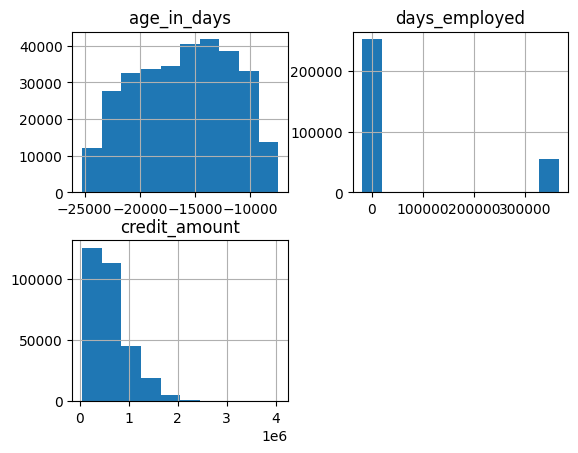

In [13]:
feature_table[['age_in_days', 'days_employed', 'credit_amount']].hist();

De leeftijd en credit tabellen zien er goed uit maar days_employed lijkt wel alsof het binair verdeelt is terwijl we door de boxplots weten dat dat niet het geval is.

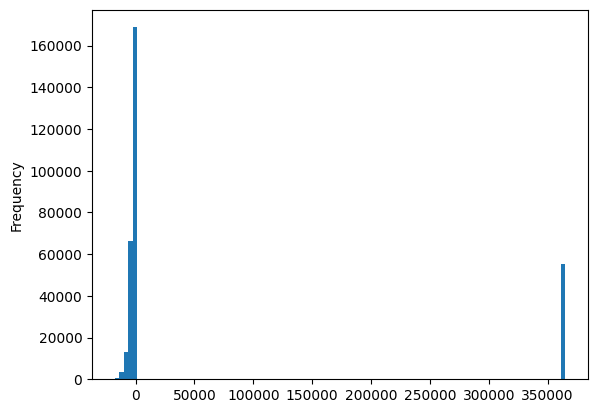

In [14]:
feature_table.days_employed.plot.hist(bins=100);

Zo te zien zijn er waardes ver boven de 350000. Dit is apart aangezien dit betekent dat deze personen 350000+ dagen in de toekomst pas een pan zullen krijgen en dat klopt niet. Om te kijken of we deze variabele nog wel goed kunnen gebruiken kunnen we kijken hoeveel waardes zich boven de 0 bevinden.

In [15]:
feature_table[feature_table.days_employed > 0].days_employed.plot.bar()

<AxesSubplot:>

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f6c8d198a60> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f6c8d1988b0> (for post_execute):


KeyboardInterrupt: 

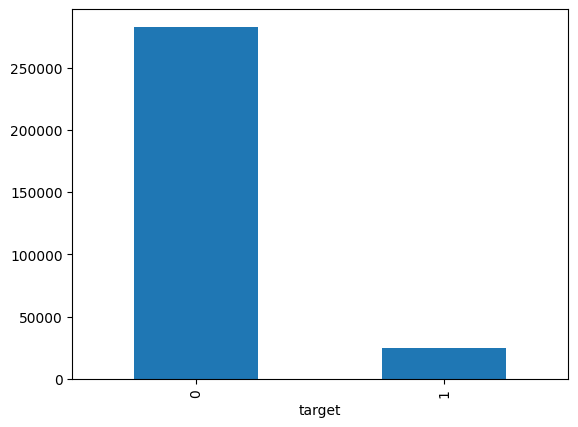

In [16]:
credit.groupby(by='target').target.count().plot.bar();

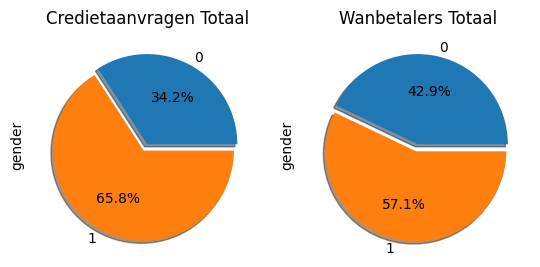

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2)

# TODO: Maak eeb stacked bar graph of wat anders ipv pie charts
credit.groupby(by='gender').gender.count().plot.pie(autopct='%1.1f%%', title='Credietaanvragen Totaal', ax=axes[0], explode=(0, 0.08), shadow=True)
non_payers = credit[credit.target == 1]
non_payers.groupby(by='gender').gender.count().plot.pie(autopct='%1.1f%%', title='Wanbetalers Totaal', ax=axes[1], explode=(0, 0.08), shadow=True);

In de bovenstaande grafieken is te zien dat het percentage man dat moeite heeft met terugbetalen van zijn kredieten groter is dan die van vrouwen.

In [18]:
credit.groupby(by='is_reachable').is_reachable.count()

is_reachable
0       574
1    306933
Name: is_reachable, dtype: int64

In de grafieken hieronder kan je zien dat een verwaarloosbaar hoeveelheid klanten niet bereikbaar was. Verder hebben maar 7,8% van de onbereikbare klanten een betalingsachterstand. Hierbij kunnen we concluderen dat bereikbaarheid niet veel zegt of de klant een betalingsachterstandzal hebben of niet.

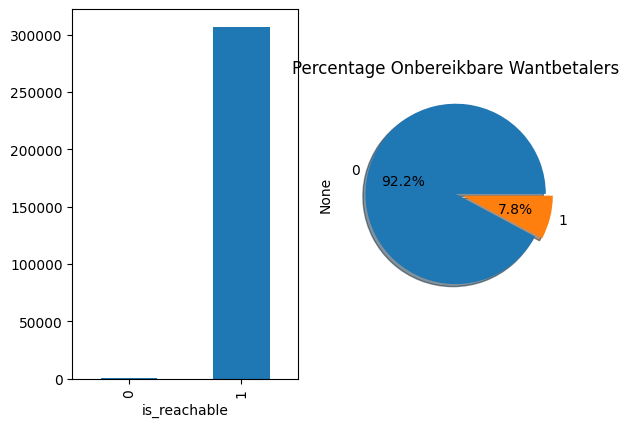

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2)

credit.groupby(by='is_reachable').is_reachable.count().plot.bar(ax=axes[0], title='')
credit[credit.is_reachable == 0].groupby(by='target').size().plot.pie(autopct='%1.1f%%', ax=axes[1], title='Percentage Onbereikbare Wantbetalers', shadow=True, explode=(0,0.08));

### NaN - waardes

Om de kwaliteit van de kolommen in onze dataset inzichtelijk  willen we weten met hoeveel NaN waardes we te maken hebben

In [20]:
credit.isnull().sum(axis = 0)

SK_ID_CURR                        0
target                            0
contract_type                     0
gender                            0
owns_car                          0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

## to do:

- CODE_GENDER  NXA eruit halen
- Kwalitatieve waardes die aangegeven zijn als ints aanpassen naar bools
- bell curves
- Correlatieonderzoek
- (nog even kijken hoeveel waardes er procentueel missen, stel de helft van de kolom mist kunnen we hem droppen denk ik, maar soms kan je ook een lege kolom voorspellen aan de hand van bijv salaris). stel age mist, maar salaris is er wel zou je bijv de gemiddelde age voor dat salaris kunnen invullen bij de lege kolom

## Baseline model

In [23]:
(credit['target'].value_counts()/credit['target'].count())*100
#baseline = np.full(len(personen), np.mean(personen.gewicht))


0    91.927013
1     8.072987
Name: target, dtype: float64

Wanneer we er van uit gaan dat iedereen een wanbetaler is, scoren we gemiddeld een acuracy van 8%

## Lineaire regressie model

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9eaf9c7c-777a-4e2e-9ddc-abf85ea1969c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>